In [57]:
import pandas as pd
from datetime import datetime

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [58]:
# portfolio of stocks

# NASDAQ Composite (^IXIC)
# Dow Jones Industrial Average (^DJI)
# S&P 500 (^GSPC)
# Russell 2000 Index (^RUT)

stocks = ['^IXIC', '^DJI', '^GSPC', '^RUT']

In [59]:
# Calculate dates properly
end_date = datetime.now()
start_date = end_date - pd.DateOffset(years=10)

# Convert to strings for yfinance if needed (yfinance accepts datetime objects too)
print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Download historical data from yf API
df = yf.download(stocks, start=start_date, end=end_date, group_by='ticker', interval='1d')

# # download data to csv
# df.to_csv("indexes_data.csv")

# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv("indexes_data.csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
df = df.dropna(how='all')

# Convert all values to float
df = df.astype(float)

# rename level 0 of the columns MultiIndex (the tickers)
df.columns = df.columns.set_levels([ticker.replace('^IXIC', 'NASDAQ').replace('^DJI', 'DOWJONES').replace('^GSPC', 'SP500').replace('^RUT', 'RUSSELL2000') for ticker in df.columns.levels[0]], level=0)

# Show the result
df.head()

Date range: 2015-09-11 to 2025-09-11


[*********************100%***********************]  4 of 4 completed



Ticker            SP500                                                       \
Price              Open         High          Low        Close        Volume   
Date                                                                           
2015-09-11  1951.449951  1961.050049  1939.189941  1961.050049  3.218590e+09   
2015-09-14  1963.060059  1963.060059  1948.270020  1953.030029  3.000200e+09   
2015-09-15  1955.099976  1983.189941  1954.300049  1978.089966  3.239860e+09   
2015-09-16  1978.020020  1997.260010  1977.930054  1995.310059  3.630680e+09   
2015-09-17  1995.329956  2020.859985  1986.729980  1990.199951  4.183790e+09   

Ticker           NASDAQ                                                       \
Price              Open         High          Low        Close        Volume   
Date                                                                           
2015-09-11  4770.729980  4822.339844  4763.149902  4822.339844  1.686190e+09   
2015-09-14  4831.979980  4832.000000  4791.080078  4805.759766  1.467740e+09   
2015-09-15  4819.319824  4872.350098  4802.089844  4860.520020  1.587460e+09   
2015-09-16  4860.430176  4893.439941  4848.149902  4889.240234  1.666380e+09   
2015-09-17  4884.109863  4960.870117  4880.500000  4893.950195  1.891510e+09   

Ticker          DOWJONES                                            \
Price               Open          High           Low         Close   
Date                                                                 
2015-09-11  16330.400391  16434.759766  16244.650391  16433.089844   
2015-09-14  16450.859375  16450.859375  16330.870117  16370.959961   
2015-09-15  16382.580078  16644.109375  16382.580078  16599.849609   
2015-09-16  16599.509766  16755.980469  16593.900391  16739.949219   
2015-09-17  16738.080078  16933.429688  16639.929688  16674.740234   

Ticker                   RUSSELL2000                                         \
Price            Volume         Open         High          Low        Close   
Date                                                                          
2015-09-11  104630000.0  1152.510010  1157.910034  1143.729980  1157.790039   
2015-09-14   92660000.0  1158.030029  1159.170044  1151.310059  1153.500000   
2015-09-15   93050000.0  1153.930054  1167.280029  1153.930054  1166.000000   
2015-09-16   99620000.0  1166.170044  1175.890015  1165.410034  1175.199951   
2015-09-17  129600000.0  1175.089966  1193.989990  1173.699951  1180.689941   

Ticker                    
Price             Volume  
Date                      
2015-09-11  3.218590e+09  
2015-09-14  3.000200e+09  
2015-09-15  3.239860e+09  
2015-09-16  3.630680e+09  
2015-09-17  4.183790e+09

In [60]:
sp500 = df['SP500']

# keep only the 'Open' and 'Close' columns
sp500 = sp500[['Open', 'Close']]

# sp500.columns lowercase
sp500.columns = [col.lower() for col in sp500.columns]

# index to datetime
sp500.index = pd.to_datetime(sp500.index)

sp500.head()

,open,close
Date,,
2015-09-11,1951.449951,1961.050049
2015-09-14,1963.060059,1953.030029
2015-09-15,1955.099976,1978.089966
2015-09-16,1978.020020,1995.310059
2015-09-17,1995.329956,1990.199951


In [61]:
# add column 'day_of_week' with the day of the week (0=Monday, 6=Sunday)
sp500['day_of_week'] = sp500.index.weekday

In [62]:
# calculate the gap percentage
sp500['gap_pct'] = ((sp500['open'] - sp500['close'].shift(1)) / sp500['close'].shift(1)) * 100

gap_threshold = 0.5  # 0.5%
# Label the gaps: Gap Up (1), Gap Down (-1), No Gap (0)
def label_gap(gap):
    if gap > gap_threshold:  # Customize threshold
        return 1  # Gap Up
    elif gap < -gap_threshold:
        return -1  # Gap Down
    else:
        return 0  # No Gap

# drop na
sp500 = sp500.dropna()

sp500['gap_label'] = sp500['gap_pct'].apply(label_gap)

In [63]:
sp500.head()

,open,close,day_of_week,gap_pct,gap_label
Date,,,,,
2015-09-14,1963.060059,1953.030029,0,0.102497,0
2015-09-15,1955.099976,1978.089966,1,0.105986,0
2015-09-16,1978.020020,1995.310059,2,-0.003536,0
2015-09-17,1995.329956,1990.199951,3,0.000997,0
2015-09-18,1989.660034,1958.030029,4,-0.027129,0


In [64]:
# count gap_label
sp500['gap_label'].value_counts()

gap_label
 0    2055
 1     243
-1     215
Name: count, dtype: int64

In [65]:
"""
entry strategy (LONG only):
group by day_of_week, gap_label == 1, entry at open (market), exit at close of the same day
"""

# Filter for gap up days only (gap_label == 1)
gap_up_days = sp500[sp500['gap_label'] == 1].copy()

# Calculate intraday return: (close - open) / open * 100
gap_up_days['intraday_return'] = ((gap_up_days['close'] - gap_up_days['open']) / gap_up_days['open']) * 100

# Group by day of the week and calculate statistics
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

strategy_results = gap_up_days.groupby('day_of_week')['intraday_return'].agg([
    'count',    # Number of gap up days
    'mean',     # Average return
    'std',      # Standard deviation
    'min',      # Worst return
    'max',      # Best return
    'sum'       # Total return
]).round(4)

# Add day names for better readability
strategy_results.index = [day_names[i] for i in strategy_results.index]

print("Gap Up Trading Strategy Results by Day of Week")
print("=" * 60)
print(strategy_results)

# Calculate win rate for each day
win_rates = gap_up_days.groupby('day_of_week').apply(
    lambda x: (x['intraday_return'] > 0).sum() / len(x) * 100
).round(2)
win_rates.index = [day_names[i] for i in win_rates.index]

print("\nWin Rate by Day of Week:")
print("-" * 30)
for day, rate in win_rates.items():
    print(f"{day}: {rate}%")

# Overall strategy performance
total_trades = len(gap_up_days)
total_return = gap_up_days['intraday_return'].sum()
avg_return = gap_up_days['intraday_return'].mean()
win_rate = (gap_up_days['intraday_return'] > 0).sum() / total_trades * 100

print(f"\nOverall Strategy Performance:")
print("-" * 30)
print(f"Total Gap Up Days: {total_trades}")
print(f"Total Return: {total_return:.2f}%")
print(f"Average Return per Trade: {avg_return:.4f}%")
print(f"Overall Win Rate: {win_rate:.2f}%")


Gap Up Trading Strategy Results by Day of Week
           count    mean     std     min     max      sum
Monday        53  0.4711  1.0507 -1.7059  3.8984  24.9668
Tuesday       55  0.3377  1.3926 -4.0589  4.3887  18.5753
Wednesday     47  0.4709  1.1109 -1.9505  4.4255  22.1315
Thursday      45  0.1702  1.2102 -2.1276  5.1485   7.6584
Friday        43  0.3422  1.5185 -5.2230  5.4876  14.7134

Win Rate by Day of Week:
------------------------------
Monday: 71.7%
Tuesday: 61.82%
Wednesday: 74.47%
Thursday: 57.78%
Friday: 74.42%

Overall Strategy Performance:
------------------------------
Total Gap Up Days: 243
Total Return: 88.05%
Average Return per Trade: 0.3623%
Overall Win Rate: 67.90%


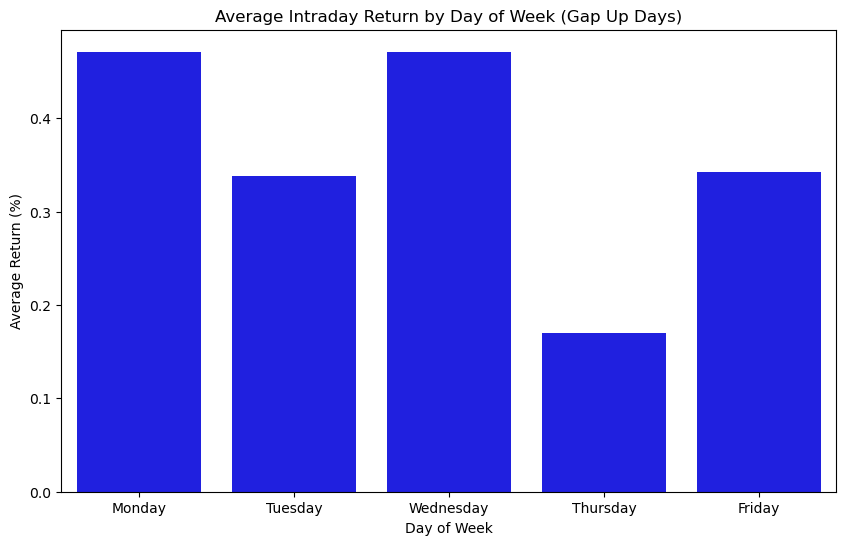

In [70]:
# plot results
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot for average returns by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=strategy_results.index, y=strategy_results['mean'], color='blue')
plt.title("Average Intraday Return by Day of Week (Gap Up Days)")
plt.xlabel("Day of Week")
plt.ylabel("Average Return (%)")
# plt.axhline(0, color='red', linestyle='--')
plt.show()

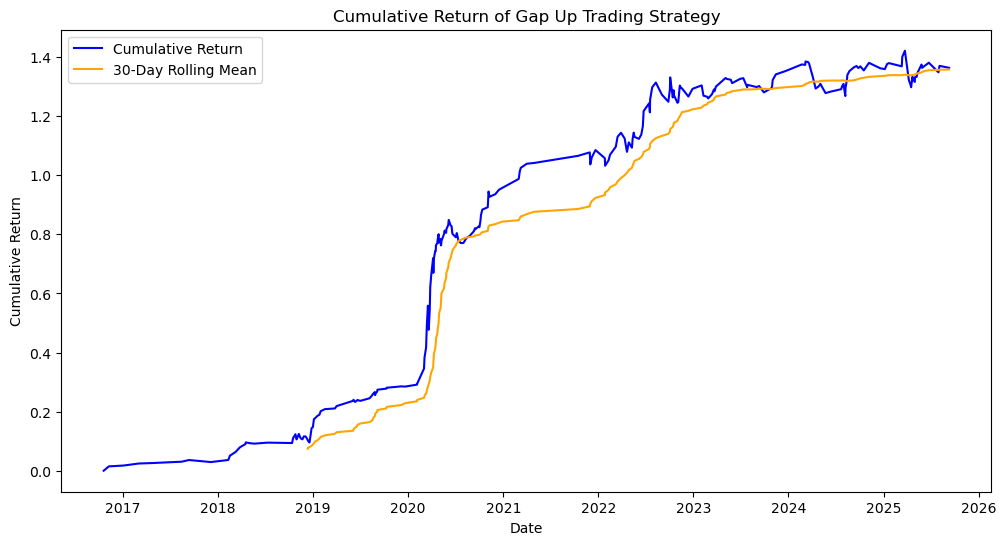

In [67]:
# plot rolling cumulative return
gap_up_days['cumulative_return'] = (1 + gap_up_days['intraday_return'] / 100).cumprod() - 1
gap_up_days['rolling_cumulative_return'] = gap_up_days['cumulative_return'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(gap_up_days.index, gap_up_days['cumulative_return'], label='Cumulative Return', color='blue')
plt.plot(gap_up_days.index, gap_up_days['rolling_cumulative_return'], label='30-Day Rolling Mean', color='orange')
plt.title("Cumulative Return of Gap Up Trading Strategy")   
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

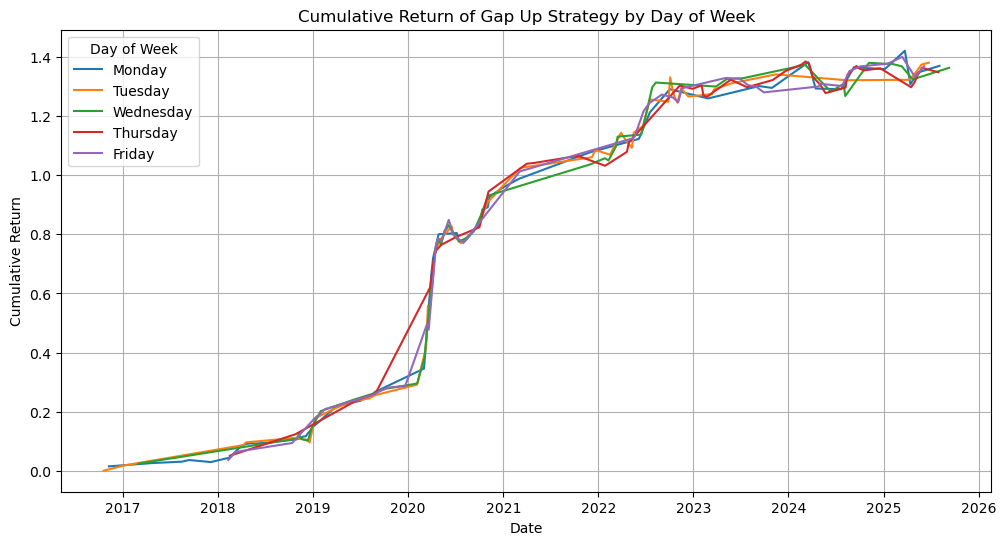


Strategy Summary:
Total Gap Up Days: 243
Total Return (%): 88.05
Average Return per Trade (%): 0.3623
Overall Win Rate (%): 67.9


In [ ]:
# plot rolling cumulative return for each day of the week
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Create individual subplot for each day of the week
for day in range(5):  # Monday to Friday
    day_data = gap_up_days[gap_up_days['day_of_week'] == day]
    if not day_data.empty:
        # Calculate separate cumulative return for this day only
        day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
        
        axes[day].plot(day_data.index, day_cumulative, 
                      label=f'{day_names[day]} ({len(day_data)} trades)', 
                      linewidth=2, color=plt.cm.Set1(day))
        axes[day].set_title(f'{day_names[day]} - Gap Up Strategy Performance')
        axes[day].set_xlabel('Date')
        axes[day].set_ylabel('Cumulative Return')
        axes[day].legend()
        axes[day].grid(True, alpha=0.3)
        axes[day].axhline(0, color='red', linestyle='--', alpha=0.5)

# Combined plot in the last subplot
axes[5].set_title('All Days Combined')
for day in range(5):  # Monday to Friday
    day_data = gap_up_days[gap_up_days['day_of_week'] == day]
    if not day_data.empty:
        day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
        axes[5].plot(day_data.index, day_cumulative, 
                    label=f'{day_names[day]}', linewidth=1.5, alpha=0.8)

axes[5].set_xlabel('Date')
axes[5].set_ylabel('Cumulative Return')
axes[5].legend(title="Day of Week")
axes[5].grid(True, alpha=0.3)
axes[5].axhline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [75]:
# summary of the strategy
summary = {
    "Total Gap Up Days": total_trades,
    "Total Return (%)": round(total_return, 2),
    "Average Return per Trade (%)": round(avg_return, 4),
    "Overall Win Rate (%)": round(win_rate, 2)
}

print("\nStrategy Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")    


Strategy Summary:
Total Gap Up Days: 243
Total Return (%): 88.05
Average Return per Trade (%): 0.3623
Overall Win Rate (%): 67.9
